Importación de paquetes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import gradio

In [ ]:
# importar archivos
crossBattlelog = pd.read_parquet('datasets/teams/battlelog_teams.parquet')
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757358 entries, 0 to 757357
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   battleTime                             757358 non-null  datetime64[ns]
 1   playertag                              757358 non-null  object        
 2   event_mode                             757358 non-null  object        
 3   event_map                              757358 non-null  object        
 4   battle_type                            757358 non-null  object        
 5   battle_result                          757358 non-null  object        
 6   battle_duration                        757358 non-null  int16         
 7   battle_trophyChange                    573018 non-null  float64       
 8   battle_team1_player1_tag               757358 non-null  object        
 9   battle_team1_player1_name              757356 no

In [ ]:
# leer brawler stats
brawlers = pd.read_parquet('datasets/brawlers/brawlers_stats.parquet')
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   starPowers.0    64 non-null     object 
 3   starPowers.1    64 non-null     object 
 4   gadgets.0       64 non-null     object 
 5   gadgets.1       64 non-null     object 
 6   Brawler         64 non-null     object 
 7   Health          64 non-null     float64
 8   Rarity          64 non-null     object 
 9   Class           64 non-null     object 
 10  Movement_Speed  64 non-null     object 
 11  Range           63 non-null     object 
 12  Reload          63 non-null     object 
 13  Speed_Num       64 non-null     int64  
 14  Range_Num       64 non-null     float64
 15  Reload_Num      63 non-null     float64
 16  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(12)
m

In [ ]:
# leer datos de mapa
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
bushList.columns = bushList.columns.str.replace('.', '_', regex=True)
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
waterList.columns = waterList.columns.str.replace('.', '_', regex=True)
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)
barrierList.columns = barrierList.columns.str.replace('.', '_', regex=True)

In [ ]:
# leer brawler winrate y userate
brawler_wr_ur = pd.read_parquet('datasets/teams/brawler_winrate_userate.parquet')
brawler_wr_ur_overall = pd.read_parquet('datasets/teams/brawler_winrate_userate_overall.parquet')

In [ ]:
# leer player stats
players = pd.read_parquet('datasets/players/players.parquet')

In [ ]:
# función para identificar a que team pertenece el player
def team_assignment(row):
    if any(row['playertag'] == tag for tag in [row.battle_team1_player1_tag, row.battle_team1_player2_tag, row.battle_team1_player3_tag]):
        return 'team1'
    elif any(row['playertag'] == tag for tag in [row.battle_team2_player1_tag, row.battle_team2_player2_tag, row.battle_team2_player3_tag]):
        return 'team2'
    else:
        return "error in team assignation for id " + str(row.name)

crossBattlelog['player_team'] = crossBattlelog.apply(team_assignment, axis=1)

crossBattlelog['player_team'].value_counts()

team2    383292
team1    374066
Name: player_team, dtype: int64

In [ ]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['battle_result'] != 'draw'].reset_index(drop=True)

In [ ]:
# crear columna winner_team
def winner_assignment(row):
	if row.battle_result == 'draw':
		return 'draw'
	elif (row.player_team == 'team1' and row.battle_result == 'victory') or (row.player_team == 'team2' and row.battle_result == 'defeat'):
		return 'team1'
	elif (row.player_team == 'team2' and row.battle_result == 'victory') or (row.player_team == 'team1' and row.battle_result == 'defeat'):
		return 'team2'
	else:
		return "error in winner assignation for id " + str(row.name)

crossBattlelog['winner_team'] = crossBattlelog.apply(winner_assignment, axis=1)

crossBattlelog['winner_team'].value_counts()

team1    376757
team2    375558
Name: winner_team, dtype: int64

In [ ]:
# crear columna winner
def subset_winner(df, team):

	df['winner'] = 'no'

	for i, winner_team in enumerate(df['winner_team']):
		if winner_team == team:
			df.loc[i, 'winner'] = 'yes'

	df = df.rename(columns={
		'battle_' + team + '_player1_tag': 'battle_player1_tag'
		,'battle_' + team + '_player1_brawler_name': 'battle_player1_brawler_name'
		,'battle_' + team + '_player1_brawler_power': 'battle_player1_brawler_power'
		,'battle_' + team + '_player1_brawler_trophies': 'battle_player1_brawler_trophies'
		,'battle_' + team + '_player2_tag': 'battle_player2_tag'
		,'battle_' + team + '_player2_brawler_name': 'battle_player2_brawler_name'
		,'battle_' + team + '_player2_brawler_power': 'battle_player2_brawler_power'
		,'battle_' + team + '_player2_brawler_trophies': 'battle_player2_brawler_trophies'
		,'battle_' + team + '_player3_tag': 'battle_player3_tag'
		,'battle_' + team + '_player3_brawler_name': 'battle_player3_brawler_name'
		,'battle_' + team + '_player3_brawler_power': 'battle_player3_brawler_power'
		,'battle_' + team + '_player3_brawler_trophies': 'battle_player3_brawler_trophies'
	})

	df = df[[	
		'event_mode'
		,'event_map'
		,'battle_type'
		,'battle_duration'
		,'battle_player1_tag'
		,'battle_player1_brawler_name'
		,'battle_player1_brawler_power'
		,'battle_player1_brawler_trophies'
		,'battle_player2_tag'
		,'battle_player2_brawler_name'
		,'battle_player2_brawler_power'
		,'battle_player2_brawler_trophies'
		,'battle_player3_tag'
		,'battle_player3_brawler_name'
		,'battle_player3_brawler_power'
		,'battle_player3_brawler_trophies'
		,'winner'
	]]

	return df

def clean_winner(team):

	if team == 'team1':
		oteam = 'team2'
	else:
		oteam = 'team1'
	
	subset = crossBattlelog[crossBattlelog['winner_team'] == team].reset_index(drop=True)

	dfwinners = subset_winner(subset, team)

	dfloosers = subset_winner(subset, oteam)

	return pd.concat([dfwinners, dfloosers], ignore_index=True)

team1 = clean_winner('team1')
team2 = clean_winner('team2')

battlelogProcess = pd.concat([team1, team2], ignore_index=True)
battlelogProcess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504630 entries, 0 to 1504629
Data columns (total 17 columns):
 #   Column                           Non-Null Count    Dtype 
---  ------                           --------------    ----- 
 0   event_mode                       1504630 non-null  object
 1   event_map                        1504630 non-null  object
 2   battle_type                      1504630 non-null  object
 3   battle_duration                  1504630 non-null  int16 
 4   battle_player1_tag               1504630 non-null  object
 5   battle_player1_brawler_name      1504630 non-null  object
 6   battle_player1_brawler_power     1504630 non-null  int8  
 7   battle_player1_brawler_trophies  1504630 non-null  int16 
 8   battle_player2_tag               1504630 non-null  object
 9   battle_player2_brawler_name      1504630 non-null  object
 10  battle_player2_brawler_power     1504630 non-null  int8  
 11  battle_player2_brawler_trophies  1504630 non-null  int16 
 12  

In [ ]:
# merge brawler stats
battlelogFinal = battlelogProcess

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

battlelogFinal = add_brawlers(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504630 entries, 0 to 1504629
Data columns (total 47 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   event_mode                             1504630 non-null  object 
 1   event_map                              1504630 non-null  object 
 2   battle_type                            1504630 non-null  object 
 3   battle_duration                        1504630 non-null  int16  
 4   battle_player1_tag                     1504630 non-null  object 
 5   battle_player1_brawler_name            1504630 non-null  object 
 6   battle_player1_brawler_power           1504630 non-null  int8   
 7   battle_player1_brawler_trophies        1504630 non-null  int16  
 8   battle_player2_tag                     1504630 non-null  object 
 9   battle_player2_brawler_name            1504630 non-null  object 
 10  battle_player2_brawler_power           150

In [ ]:
# merge player stats
def merge_playerstats(df, prefix):
	df = pd.merge(left=df, right=players.add_prefix(prefix), on=prefix + 'tag', how='inner')
	return df

battlelogFinal = merge_playerstats(battlelogFinal, 'battle_player1_')
battlelogFinal = merge_playerstats(battlelogFinal, 'battle_player2_')
battlelogFinal = merge_playerstats(battlelogFinal, 'battle_player3_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500226 entries, 0 to 1500225
Data columns (total 62 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   event_mode                             1500226 non-null  object        
 1   event_map                              1500226 non-null  object        
 2   battle_type                            1500226 non-null  object        
 3   battle_duration                        1500226 non-null  int16         
 4   battle_player1_tag                     1500226 non-null  object        
 5   battle_player1_brawler_name            1500226 non-null  object        
 6   battle_player1_brawler_power           1500226 non-null  int8          
 7   battle_player1_brawler_trophies        1500226 non-null  int16         
 8   battle_player2_tag                     1500226 non-null  object        
 9   battle_player2_brawler_name        

In [ ]:
# merge map data
battlelogFinal = battlelogFinal.merge(barrierList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(bushList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(waterList, how='left', on='event_map')
battlelogFinal['waterProp'] = battlelogFinal['waterProp'].fillna(0)
battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500226 entries, 0 to 1500225
Data columns (total 67 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   event_mode                             1500226 non-null  object        
 1   event_map                              1500226 non-null  object        
 2   battle_type                            1500226 non-null  object        
 3   battle_duration                        1500226 non-null  int16         
 4   battle_player1_tag                     1500226 non-null  object        
 5   battle_player1_brawler_name            1500226 non-null  object        
 6   battle_player1_brawler_power           1500226 non-null  int8          
 7   battle_player1_brawler_trophies        1500226 non-null  int16         
 8   battle_player2_tag                     1500226 non-null  object        
 9   battle_player2_brawler_name        

In [ ]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event_mode', 'event_map', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event_mode', 'event_map']
		,right_on=[prefix + 'brawlername', prefix + 'event_mode', prefix + 'event_map']
		,how='left'
		,suffixes=('','_w'))
	return df

battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500226 entries, 0 to 1500225
Data columns (total 85 columns):
 #   Column                                      Non-Null Count    Dtype         
---  ------                                      --------------    -----         
 0   event_mode                                  1500226 non-null  object        
 1   event_map                                   1500226 non-null  object        
 2   battle_type                                 1500226 non-null  object        
 3   battle_duration                             1500226 non-null  int16         
 4   battle_player1_tag                          1500226 non-null  object        
 5   battle_player1_brawler_name                 1500226 non-null  object        
 6   battle_player1_brawler_power                1500226 non-null  int8          
 7   battle_player1_brawler_trophies             1500226 non-null  int16         
 8   battle_player2_tag                          1500226 non-null  

In [ ]:
# merge winrate y userate overall
def add_wr_ur_oa(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur_overall[['brawlername', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name']
		,right_on=[prefix + 'brawlername']
		,how='left'
		,suffixes=('','_overall'))
	return df

battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500226 entries, 0 to 1500225
Data columns (total 97 columns):
 #   Column                                              Non-Null Count    Dtype         
---  ------                                              --------------    -----         
 0   event_mode                                          1500226 non-null  object        
 1   event_map                                           1500226 non-null  object        
 2   battle_type                                         1500226 non-null  object        
 3   battle_duration                                     1500226 non-null  int16         
 4   battle_player1_tag                                  1500226 non-null  object        
 5   battle_player1_brawler_name                         1500226 non-null  object        
 6   battle_player1_brawler_power                        1500226 non-null  int8          
 7   battle_player1_brawler_trophies                     1500226 non-null  in

In [ ]:
plt.style.use('ggplot')

In [ ]:
# crear columna avg power
def create_avg(row, column):
    return (row['battle_player1_'+ column] + row['battle_player2_'+ column] + row['battle_player3_'+ column]) / 3

cols = ['brawler_power',
'brawler_Range_Num',
'brawler_trophies',
'brawler_Health',
'brawler_Speed_Num',
'brawler_winrate',
'brawler_winrate_overall',
'brawler_userate',
'brawler_userate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

for col in cols:
	battlelogFinal['avg_' + col] = battlelogFinal.apply(lambda row: create_avg(row, col), axis=1)


KeyError: 'avg_brawler_trophies'

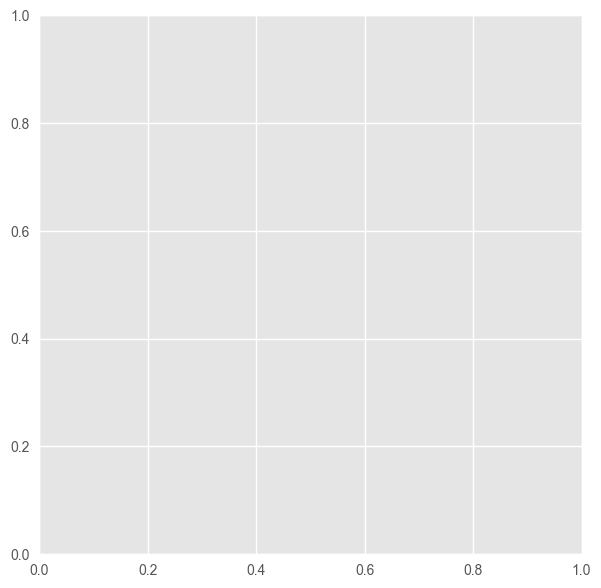

In [ ]:

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['avg_brawler_trophies'], bins=40)
plt.show()


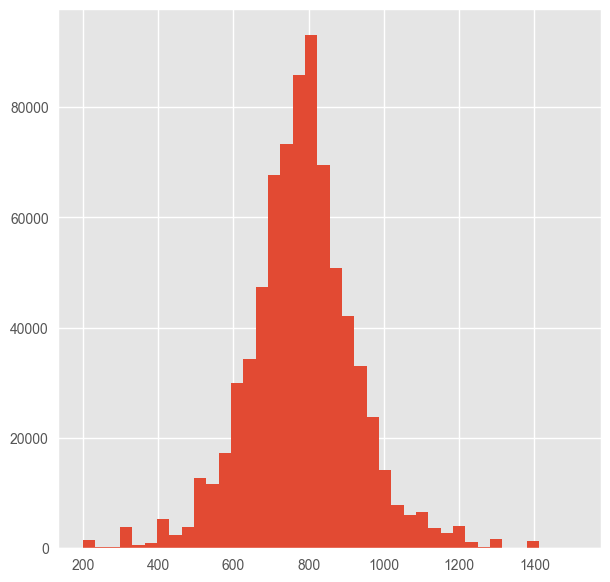

In [ ]:

# subset avg trophies
battlelogFinal = battlelogFinal[battlelogFinal['avg_brawler_trophies'] > 200]
fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['avg_brawler_trophies'], bins=40)
plt.show()

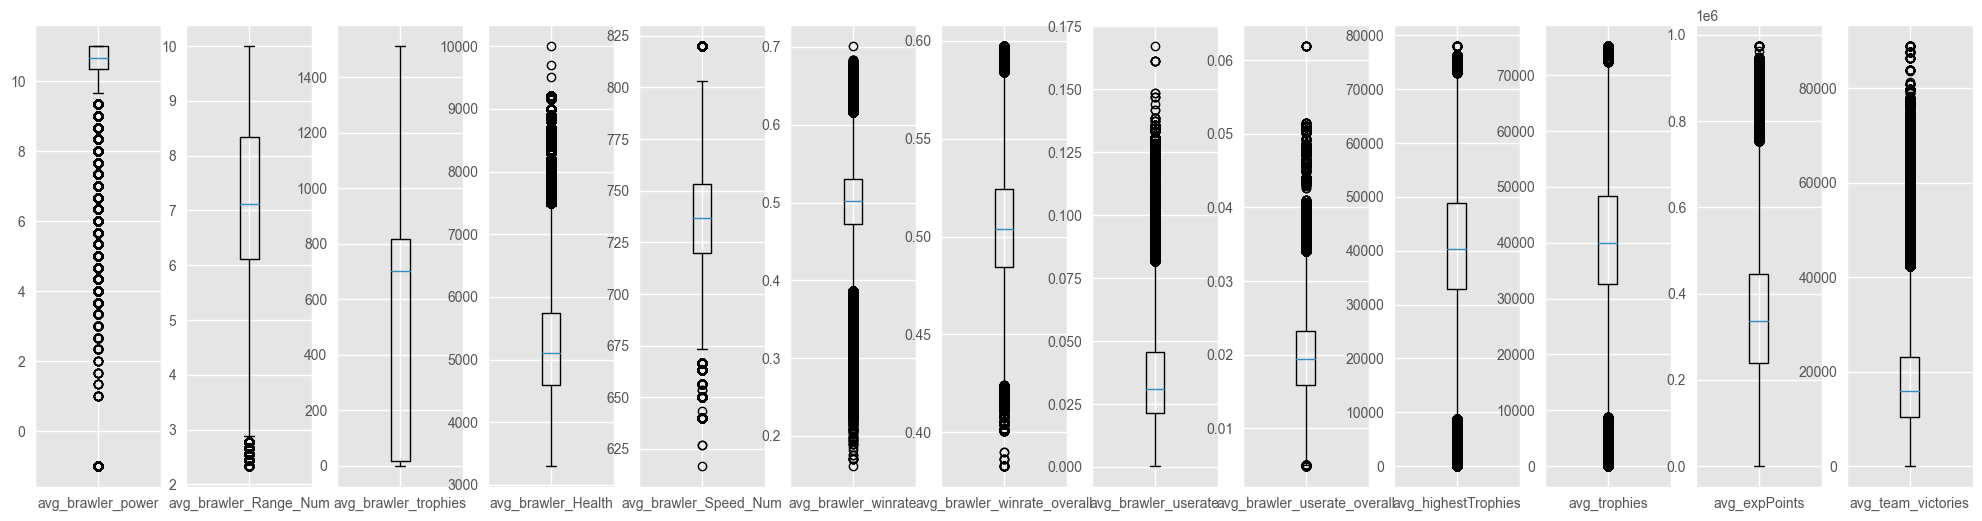

In [ ]:
# graficar
fig, ax = plt.subplots(1, len(cols), figsize=(25, 6))
for i, col in enumerate(cols):
    ax[i].boxplot(battlelogFinal['avg_' + col])
    ax[i].set_xticklabels(['avg_' + col])
plt.show()

In [ ]:

def eliminar_outliers(df, columna):
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3-q1 # Rango intercuartílico
    umbral_inferior  = q1-1.5*iqr # Umbral inferior
    umbral_superior = q3+1.5*iqr # Umbral superior

    df_sin_outliers = df.loc[(df[columna] > umbral_inferior) & (df[columna] < umbral_superior)]

    return df_sin_outliers
	
print(battlelogFinal.shape)
for col in cols:
	battlelogFinal = eliminar_outliers(battlelogFinal, 'avg_' + col)
print(battlelogFinal.shape)

(1500226, 110)
(1130405, 110)


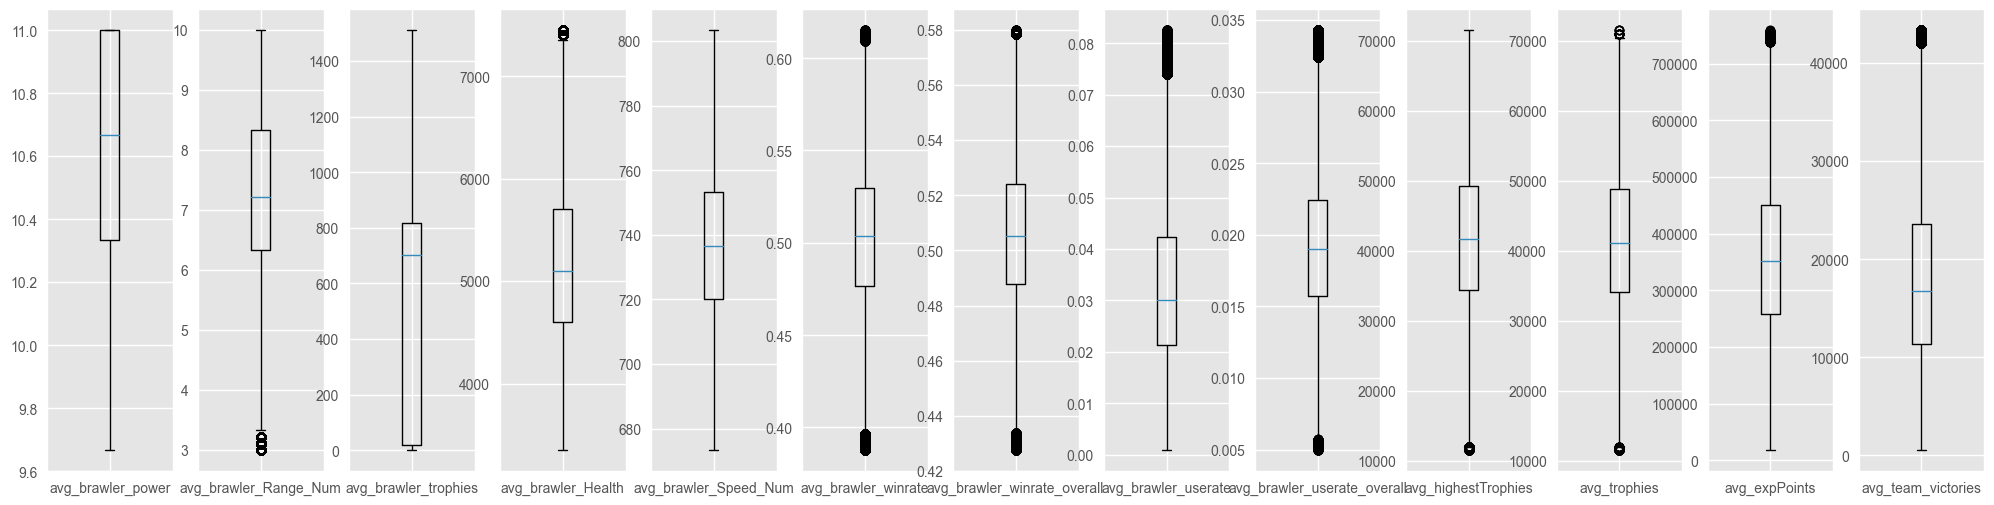

In [ ]:

fig, ax = plt.subplots(1, len(cols), figsize=(25, 6))
for i, col in enumerate(cols):
    ax[i].boxplot(battlelogFinal['avg_' + col])
    ax[i].set_xticklabels(['avg_' + col])
plt.show()

In [109]:
# best brawlers
def get_min_max_rest(row, column_names):
    a, b, c = row[column_names[0]], row[column_names[1]], row[column_names[2]]
    min_val = min(a, b, c)
    max_val = max(a, b, c)
    # rest_val = (a + b + c) - min_val - max_val
    # return min_val, max_val, rest_val
    return min_val, max_val

def order_rows(df, column):
	column_names = ['battle_player1_' + column, 'battle_player2_' + column, 'battle_player3_' + column]
	# min_vals, max_vals, rest_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	min_vals, max_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	# df[column + '_min'] = min_vals
	# df[column + '_max'] = max_vals
	# df['battle_' + column + '_rest'] = rest_vals
	return min_vals, max_vals

cols = ['brawler_power',
'brawler_Range_Num',
'brawler_trophies',
'brawler_Health',
'brawler_Speed_Num',
'brawler_winrate',
'brawler_winrate_overall',
'brawler_userate',
'brawler_userate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

for col in cols:
	battlelogFinal[col + '_min'], battlelogFinal[col + '_max'] = order_rows(battlelogFinal, col)

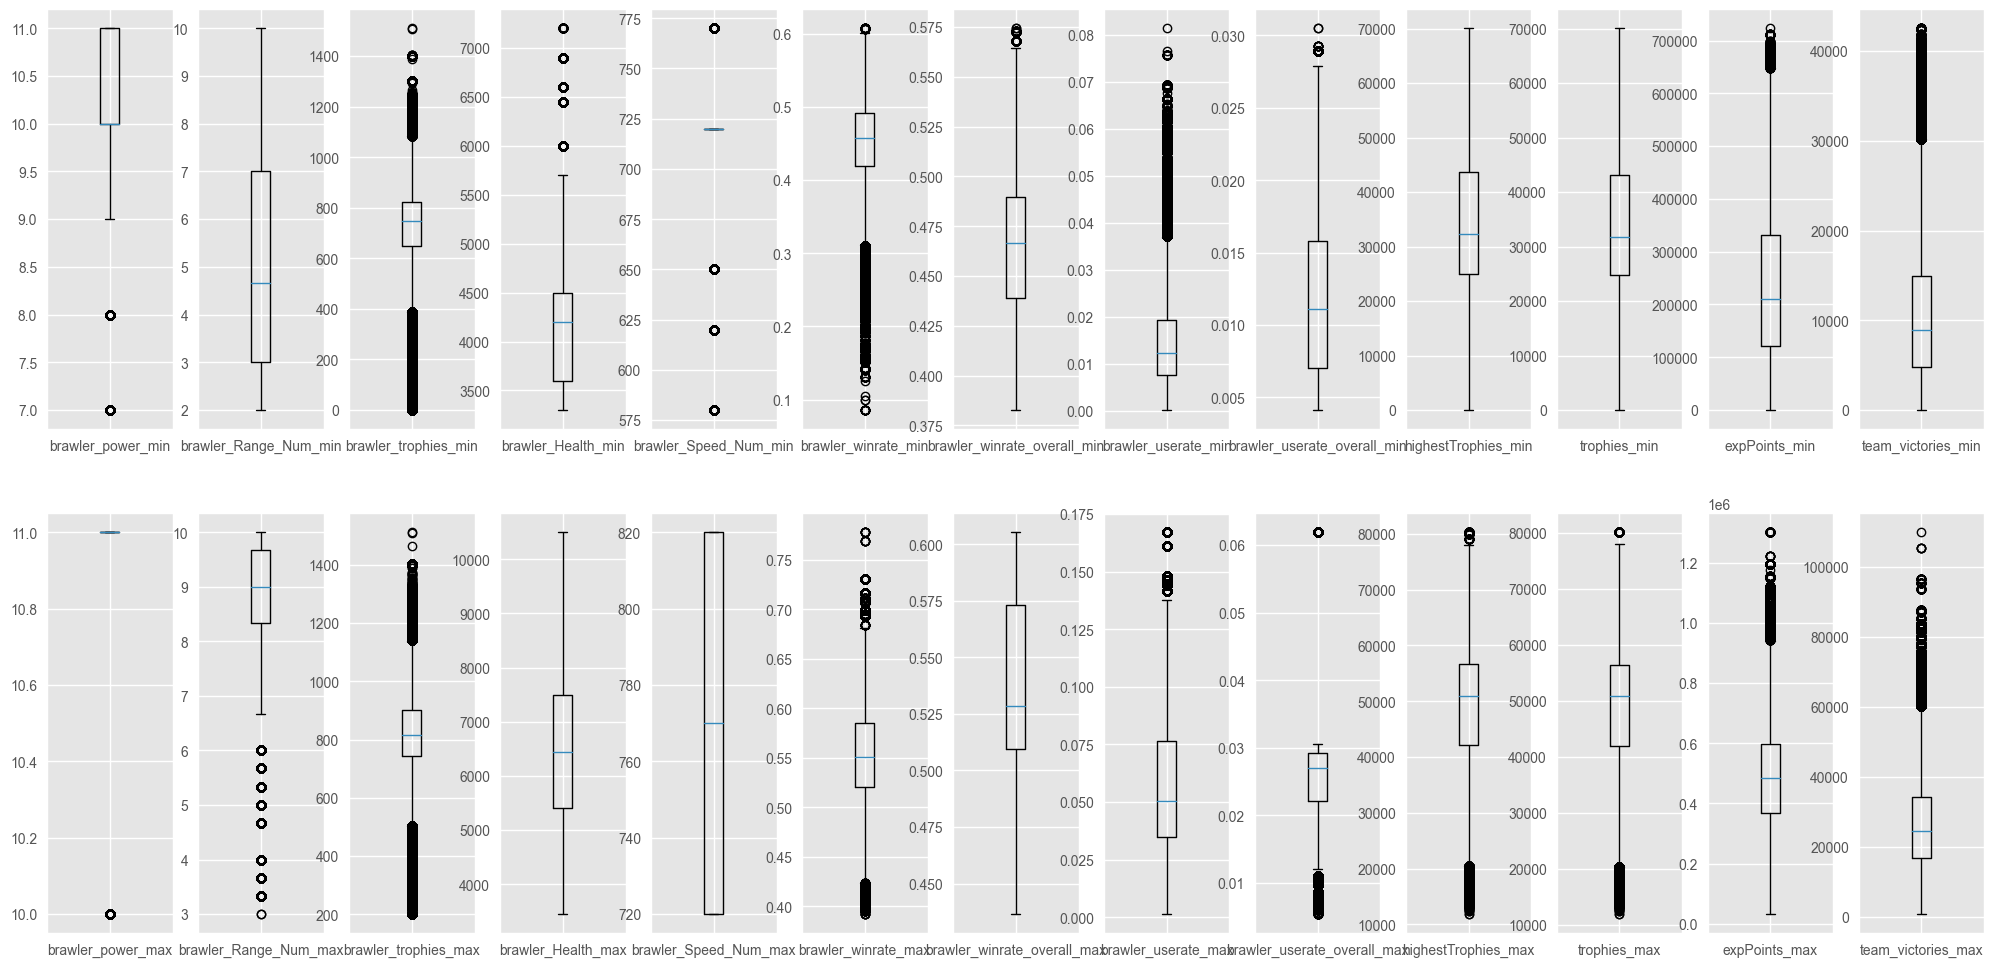

In [100]:
# graficar
fig, ax = plt.subplots(2, len(cols), figsize=(25, 12))
for i, col in enumerate(cols):
    ax[0, i].boxplot(battlelogFinal[col + '_min'])
    ax[0, i].set_xticklabels([col + '_min'])
    ax[1, i].boxplot(battlelogFinal[col + '_max'])
    ax[1, i].set_xticklabels([col + '_max'])
plt.show()

In [101]:
print(battlelogFinal.shape)
for col in cols:
	battlelogFinal = eliminar_outliers(battlelogFinal, col + '_min')
	battlelogFinal = eliminar_outliers(battlelogFinal, col + '_max')
print(battlelogFinal.shape)

(761728, 136)
(0, 136)


In [ ]:
# definición final de columnas
def subset_battlelog(gamemode):

	df = subset_complete()[battlelogFinal['event_mode'] == gamemode].reset_index(drop=True)

	return df

def subset_complete():
	df = battlelogFinal[[
	'winner'
	,'event_mode'
	,'event_map'
	,'battle_avgpower'
	,'battle_brawler_power_min'
	,'battle_brawler_power_max'
	,'battle_avgbrawlertrophies'
	,'battle_brawler_trophies_min'
	,'battle_brawler_trophies_max'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'battle_avghighestTrophies'
	,'battle_highestTrophies_min'
	,'battle_highestTrophies_max'
	,'battle_avghealth'
	,'battle_brawler_Health_min'
	,'battle_brawler_Health_max'
	,'battle_avgrange'
	,'battle_brawler_Range_Num_min'
	,'battle_brawler_Range_Num_max'
	,'battle_avgspeed'
	,'battle_brawler_Speed_Num_min'
	,'battle_brawler_Speed_Num_max'
	,'battle_avgwinrate'
	,'battle_brawler_winrate_min'
	,'battle_brawler_winrate_max'
	,'battle_avgwinrate_overall'
	,'battle_brawler_winrate_overall_min'
	,'battle_brawler_winrate_overall_max'
	,'battle_avguserate'
	,'battle_brawler_userate_min'
	,'battle_brawler_userate_max'
	,'battle_avguserate_overall'
	,'battle_brawler_userate_overall_min'
	,'battle_brawler_userate_overall_max'
	,'battle_avgteam_victories'
	,'battle_team_victories_min'
	,'battle_team_victories_max'
	,'battle_avgexpPoints'
	,'battle_expPoints_min'
	,'battle_expPoints_max'
	]].reset_index(drop=True)
	
	df['winner'] = df['winner'].replace({'yes': 1, 'no': 0}).astype(int)

	df['battle_avgbrawlertrophies'] = np.log(df['battle_avgtrophies'])
	df['battle_brawler_trophies_min'] = np.log(df['battle_brawler_trophies_min'])
	df['battle_brawler_trophies_max'] = np.log(df['battle_brawler_trophies_max'])
	df['battle_avgtrophies'] = np.log(df['battle_avgtrophies'])
	df['battle_trophies_min'] = np.log(df['battle_trophies_min'])
	df['battle_trophies_max'] = np.log(df['battle_trophies_max'])
	df['battle_avghighestTrophies'] = np.log(df['battle_avghighestTrophies'])
	df['battle_highestTrophies_min'] = np.log(df['battle_highestTrophies_min'])
	df['battle_highestTrophies_max'] = np.log(df['battle_highestTrophies_max'])
	df['battle_avghealth'] = np.log(df['battle_avghealth'])
	df['battle_brawler_Health_min'] = np.log(df['battle_brawler_Health_min'])
	df['battle_brawler_Health_max'] = np.log(df['battle_brawler_Health_max'])
	df['battle_avgspeed'] = np.log(df['battle_avgspeed'])
	df['battle_brawler_Speed_Num_min'] = np.log(df['battle_brawler_Speed_Num_min'])
	df['battle_brawler_Speed_Num_max'] = np.log(df['battle_brawler_Speed_Num_max'])
	df['battle_avgteam_victories'] = np.log(df['battle_avgteam_victories'])
	df['battle_team_victories_min'] = np.log(df['battle_team_victories_min'])
	df['battle_team_victories_max'] = np.log(df['battle_team_victories_max'])
	df['battle_avgexpPoints'] = np.log(df['battle_avgexpPoints'])
	df['battle_expPoints_min'] = np.log(df['battle_expPoints_min'])
	df['battle_expPoints_max'] = np.log(df['battle_expPoints_max'])

	return df

In [ ]:
df = subset_complete()

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=df, orient='h', ax=ax)
plt.show()

In [ ]:
# heatmap de correlaciones
# df = subset_battlelog('hotZone')

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 7}, cmap='BuPu', ax=ax)
plt.show()

In [ ]:
# completo
df = subset_complete()
df.shape

Second package import

In [ ]:
import os
from pycaret.classification import *
import xgboost
import catboost
from sklearn.model_selection import train_test_split

In [ ]:
# cambiar working directory
print(os.getcwd())
os.chdir('machine_learning')
print(os.getcwd())

In [ ]:
# generar set de testing y training
seed=14683

train, test = train_test_split(df, test_size = 0.5, random_state=seed, stratify=df['winner'])

train.shape

In [ ]:
# setup model
session_1 = setup(
	data = train,
	target = 'winner',
	fix_imbalance = True,
    feature_selection= True,
	remove_outliers=True,
	log_experiment = True,
    use_gpu=False)

In [ ]:
#comparación de modelos
model = compare_models(include=['rf','gbc','lightgbm','ada','catboost','xgboost'])

In [ ]:
#try model blender

# example:
# train a few models
# lr = create_model('lr')
# dt = create_model('dt')
# knn = create_model('knn')

# blend models
# blender = blend_models([lr, dt, knn])
# blender_tuned = tune_model(blender, optimize = 'F1')

In [ ]:
# tunear el mejor modelo
model_tuned = tune_model(model, optimize = 'F1')

In [ ]:
# compare hyperparameters
print(model)

print(model_tuned)

In [ ]:
# interpret model
interpret_model(model_tuned)

In [ ]:
plot_model(model_tuned, plot='confusion_matrix', save=True)
plot_model(model_tuned, plot='feature', save=True)
plot_model(model_tuned, plot='calibration', save=True)

In [ ]:
# finalizar modelo
model_finalized = finalize_model(model_tuned)
predictions = predict_model(model_finalized, data = test)

In [ ]:
# create_app(model_finalized)

In [ ]:
save_model(model_finalized, 'models/catboost')

In [ ]:
predictions.to_csv('/Users/alniquia/OneDrive - Telefonica/Documents/Projects/BrawlStars_Model/datasets/predictions/predictions_lc.csv')